In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
n_samples_per_class = 100
input_dim = 5   # initial embedding dimension
proj_dim = 2    # 2D projection for visualization
temperature = 0.1
num_epochs = 200
learning_rate = 1e-2

# Create synthetic data:
# We'll generate two clusters:
# Class 1 ("correct"): centered at +1, and Class 0 ("incorrect"): centered at -1.
correct_embeddings = torch.randn(n_samples_per_class, input_dim) + 1.0
incorrect_embeddings = torch.randn(n_samples_per_class, input_dim) - 1.0

# Stack the data
X = torch.cat([correct_embeddings, incorrect_embeddings], dim=0)  # shape: [200, 5]
# Create labels: 1 for correct, 0 for incorrect
labels = torch.cat([torch.ones(n_samples_per_class), torch.zeros(n_samples_per_class)], dim=0)

# We'll use these as our "initial embeddings"
print("Data shape:", X.shape)

Data shape: torch.Size([200, 5])


In [3]:
# Define a simple projection layer: linear mapping from 5d -> 2d.
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, proj_dim):
        super(ProjectionNet, self).__init__()
        self.projection = nn.Linear(input_dim, proj_dim)
        
    def forward(self, x):
        return self.projection(x)

# Initialize the projection network
proj_net = ProjectionNet(input_dim, proj_dim)
proj_net

ProjectionNet(
  (projection): Linear(in_features=5, out_features=2, bias=True)
)

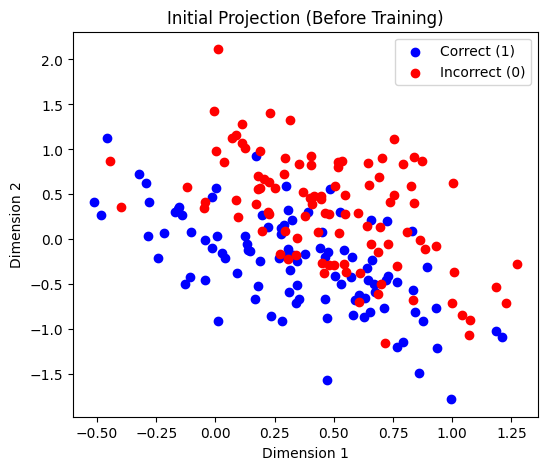

In [4]:
# Define an InfoNCE-style contrastive loss.
# For each anchor, positives are samples with the same label (excluding itself),
# and negatives are samples with a different label.
def contrastive_loss(z, labels, temperature=0.1):
    """
    z: [N, proj_dim] - projected embeddings (not necessarily normalized)
    labels: [N] - binary labels (0 or 1)
    """
    # Normalize the embeddings
    z_norm = F.normalize(z, dim=1)
    # Compute similarity matrix: [N, N]
    sim_matrix = torch.matmul(z_norm, z_norm.t()) / temperature
    
    N = z.shape[0]
    loss = 0.0
    count = 0
    for i in range(N):
        # Find indices of positives (same label, exclude self)
        pos_indices = (labels == labels[i]).nonzero(as_tuple=True)[0]
        pos_indices = pos_indices[pos_indices != i]
        # Find indices of negatives (different label)
        neg_indices = (labels != labels[i]).nonzero(as_tuple=True)[0]
        
        if len(pos_indices) == 0:
            continue  # skip if no positive available
        
        # For stability, use log-sum-exp over all other samples in the same batch.
        # For sample i, consider all other samples (both positive and negative).
        # The denominator will be the log-sum-exp over all j != i.
        mask = torch.ones(N, dtype=torch.bool)
        mask[i] = False
        denom = torch.logsumexp(sim_matrix[i][mask], dim=0)
        
        # For each positive, compute loss contribution.
        for j in pos_indices:
            loss += -sim_matrix[i, j] + denom
            count += 1
    if count > 0:
        return loss / count
    else:
        return torch.tensor(0.0, device=z.device)

# Utility: Plot the 2D projections with different colors for labels
def plot_projections(z, labels, title="Projection", ax=None):
    z_np = z.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    if ax is None:
        plt.figure(figsize=(6,5))
        plt.scatter(z_np[labels_np==1, 0], z_np[labels_np==1, 1], c='blue', label='Correct (1)')
        plt.scatter(z_np[labels_np==0, 0], z_np[labels_np==0, 1], c='red', label='Incorrect (0)')
        plt.legend()
        plt.title(title)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()
    else:
        ax.scatter(z_np[labels_np==1, 0], z_np[labels_np==1, 1], c='blue', label='Correct (1)')
        ax.scatter(z_np[labels_np==0, 0], z_np[labels_np==0, 1], c='red', label='Incorrect (0)')
        ax.legend()
        ax.set_title(title)

# Plot the initial projection before training.
with torch.no_grad():
    initial_proj = proj_net(X)
plot_projections(initial_proj, labels, title="Initial Projection (Before Training)")

 25%|██▌       | 50/200 [02:24<07:23,  2.96s/it]

Epoch 50/200, Loss: 4.7333


 50%|█████     | 100/200 [04:41<03:52,  2.33s/it]

Epoch 100/200, Loss: 4.7294


 75%|███████▌  | 150/200 [06:57<02:27,  2.95s/it]

Epoch 150/200, Loss: 4.7294


100%|██████████| 200/200 [09:26<00:00,  2.83s/it]

Epoch 200/200, Loss: 4.7294


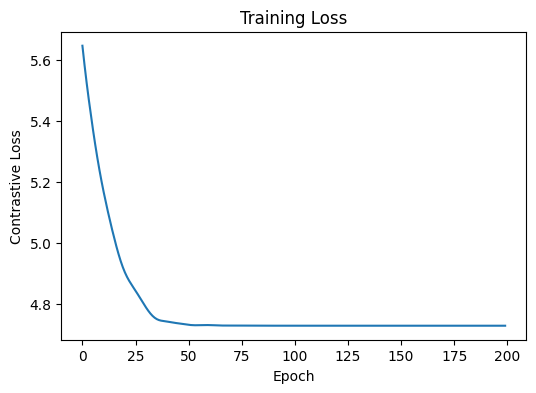

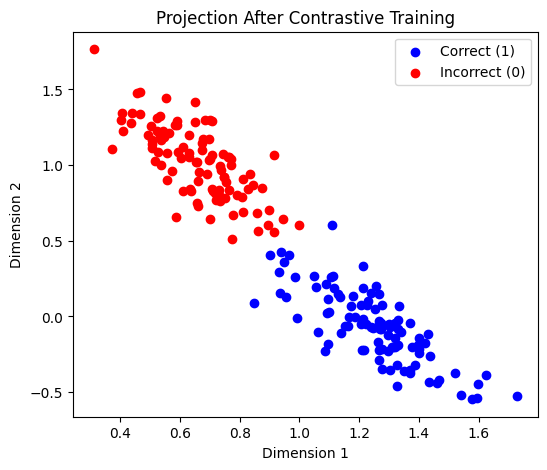

In [8]:
from tqdm import tqdm

# Set up optimizer for the projection network
optimizer = optim.Adam(proj_net.parameters(), lr=learning_rate)

# Training loop for contrastive learning
loss_history = []
for epoch in tqdm(range(num_epochs)):
    proj_net.train()
    optimizer.zero_grad()
    
    z = proj_net(X)  # project the synthetic embeddings
    loss = contrastive_loss(z, labels, temperature)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Training Loss")
plt.show()

# Plot the projection after training
with torch.no_grad():
    trained_proj = proj_net(X)
plot_projections(trained_proj, labels, title="Projection After Contrastive Training")


In [3]:
# read f1b2c1f14e3596233ec4e19d56d502136e835e1175c8f6a21829d0a803a77d8b.pt

import torch

f = torch.load("../data/GSM8K/Meta-Llama-3.1-8B-Instruct-quantized.w8a8/final_hidden_states/train/f1b2c1f14e3596233ec4e19d56d502136e835e1175c8f6a21829d0a803a77d8b.pt")
f.shape

/tmp/ipykernel_188938/191326515.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load("../data/GSM8K/Meta-Llama-3.1-8B-Instruct-quantized.w8a8/final_hidden_stat

torch.Size([4096])

In [4]:
# see how many .pt items are there in "../data/GSM8K/Meta-Llama-3.1-8B-Instruct-quantized.w8a8/final_hidden_states/train/"

import os

path = "../data/GSM8K/Meta-Llama-3.1-8B-Instruct-quantized.w8a8/final_hidden_states/train/"
files = os.listdir(path)
pt_files = [f for f in files if f.endswith(".pt")]
len(pt_files)

1000